In [ ]:
#@title Copyright 2019 The Lifetime Value Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# KDD Cup 98 LTV Prediction

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/lifetime_value/blob/master/notebooks/kdd_cup_98/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/lifetime_value/blob/master/notebooks/kdd_cup_98/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [1]:
import os

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from typing import Sequence

# install and import ltv
import lifetime_value as ltv

In [2]:
tfd = tfp.distributions
%config InlineBackend.figure_format='retina'
sns.set_style('whitegrid')

## Configs

In [3]:
MODEL = 'dnn'
LOSS = 'ziln' # @param { isTemplate: true, type: 'string'} ['mse', 'ziln']
LEARNING_RATE = 0.001  # @param { isTemplate: true}
VERSION = 0 # @param { isTemplate: true, type: 'integer'}
OUTPUT_CSV_FOLDER = '/tmp/lifetime-value/kdd_cup_98/result' # @param { isTemplate: true, type: 'string'}

## Load data

Download kdd_cup_98 data to /tmp/lifetime-value/kdd_cup_98

In [4]:
%%shell
mkdir -p /tmp/lifetime-value/kdd_cup_98
wget https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/cup98lrn.zip -P /tmp/lifetime-value/kdd_cup_98/
wget https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/cup98val.zip -P /tmp/lifetime-value/kdd_cup_98/
wget https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/valtargt.txt -P /tmp/lifetime-value/kdd_cup_98/
cd /tmp/lifetime-value/kdd_cup_98/
unzip cup98lrn.zip
unzip cup98val.zip

--2024-08-28 09:35:17--  https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/cup98lrn.zip
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36468735 (35M) [application/zip]
Saving to: ‘/tmp/lifetime-value/kdd_cup_98/cup98lrn.zip’

cup98lrn.zip        100%[===================>]  34.78M  48.8MB/s    in 0.7s    

2024-08-28 09:35:18 (48.8 MB/s) - ‘/tmp/lifetime-value/kdd_cup_98/cup98lrn.zip’ saved [36468735/36468735]

--2024-08-28 09:35:18--  https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/cup98val.zip
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36763018 (35M) [application/zip]
Saving to: ‘/tmp/lifetime-value/kdd_cup_98/cup98val.zip’

cup98val.zip        100%[===================>]  

In [5]:
df_train = pd.read_csv('/tmp/lifetime-value/kdd_cup_98/cup98LRN.txt')
num_train = df_train.shape[0]
df_eval = pd.read_csv('/tmp/lifetime-value/kdd_cup_98/cup98VAL.txt')
df_eval_target = pd.read_csv('/tmp/lifetime-value/kdd_cup_98/valtargt.txt')
df_eval = df_eval.merge(df_eval_target, on='CONTROLN')

<ipython-input-5-8d470a0a4c87>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('/tmp/lifetime-value/kdd_cup_98/cup98LRN.txt')
<ipython-input-5-8d470a0a4c87>:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eval = pd.read_csv('/tmp/lifetime-value/kdd_cup_98/cup98VAL.txt')


In [6]:
df = pd.concat([df_train, df_eval], axis=0, sort=True)

In [7]:
import pandas as pd
import numpy as np

# Set the random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 1000

# Generate 5 continuous variables
X = pd.DataFrame({
    'var1': np.random.normal(loc=50, scale=10, size=n_samples),
    'var2': np.random.normal(loc=100, scale=20, size=n_samples),
    'var3': np.random.normal(loc=150, scale=30, size=n_samples),
    'var4': np.random.normal(loc=200, scale=40, size=n_samples),
    'var5': np.random.normal(loc=250, scale=50, size=n_samples),
})

# Generate LTV as the target variable (a function of the above variables + some noise)
LTV = 2 * X['var1'] + 0.5 * X['var2'] + 0.3 * X['var3'] + 0.1 * X['var4'] + 0.05 * X['var5'] + np.random.normal(loc=0, scale=10, size=n_samples)

# Combine into a single DataFrame
df = X.copy()
df['LTV'] = LTV

df.head()


,var1,var2,var3,var4,var5,LTV
0,54.967142,127.987109,129.744652,123.687698,206.825320,231.323672
1,48.617357,118.492674,145.664440,165.584600,248.439826,224.626693
2,56.476885,101.192607,126.227402,183.455779,250.900844,214.352483
3,65.230299,87.061264,140.761154,275.507506,273.631517,254.151000
4,47.658466,113.964466,93.191560,222.262125,181.657082,218.893991


In [8]:
num_train = int(0.8*(df.shape[0]))

In [9]:
num_train

800

In [10]:
df_train = df.iloc[:num_train]
df_eval = df.iloc[num_train:]
df_eval_target = df_eval.LTV


## Label distribution

In [11]:
y = df['LTV'][:num_train]

In [12]:
def plot_hist_log_scale(y):
  max_val = y.max() + 1.
  ax = pd.Series(y).hist(
      figsize=(8, 5), bins = 10 ** np.linspace(0., np.log10(max_val), 20))

  plt.xlabel('Donation ($)')
  plt.ylabel('Count')
  # plt.title('Histogram of LTV')
  plt.xticks(rotation='horizontal')
  plt.legend(loc='upper left')
  ax.set_xscale('log')
  ax.grid(False)
  # Hide the right and top spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  # Only show ticks on the left and bottom spines
  ax.yaxis.set_ticks_position('left')
  ax.xaxis.set_ticks_position('bottom')
  plt.show()

  fig = ax.get_figure()


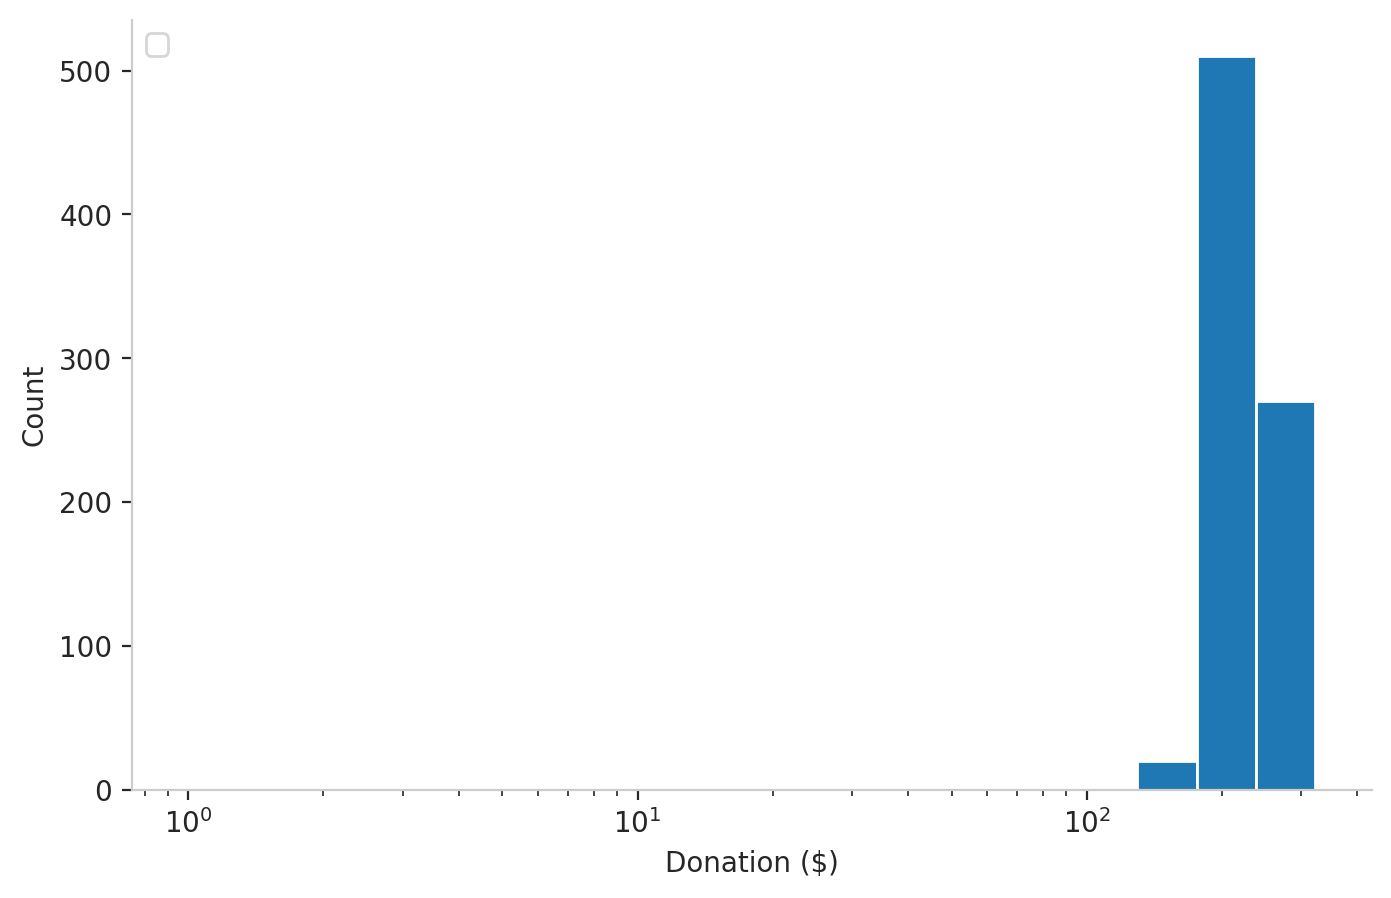

In [13]:
plot_hist_log_scale(y[y>0])

## Preprocess features

### All

In [14]:
df.columns

Index(['var1', 'var2', 'var3', 'var4', 'var5', 'LTV'], dtype='object')

In [15]:
NUMERIC_FEATURES = ['var1', 'var2', 'var3', 'var4', 'var5']
CATEGORICAL_FEATURES = []
ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

## Train/eval split

In [ ]:
y_train = y_train.reshape(-1, 1)
y_eval = y_eval.reshape(-1, 1)


In [23]:
def dnn_split(df):
  df_train = df.iloc[:num_train]
  df_eval = df.iloc[num_train:]

  def feature_dict(df):
    features = {k: v.values for k, v in dict(df[CATEGORICAL_FEATURES]).items()}
    features['numeric'] = df[NUMERIC_FEATURES].astype('float32').values
    return features

  x_train, y_train = feature_dict(df_train), df_train['LTV'].astype(
      'float32').values
  x_eval, y_eval = feature_dict(df_eval), df_eval['LTV'].astype(
      'float32').values

  return x_train, x_eval, y_train.reshape(-1, 1), y_eval.reshape(-1, 1)

## Model

In [24]:
def embedding_dim(x):
  return int(x**.25) + 1






def dnn_model(output_units):
  numeric_input = tf.keras.layers.Input(
      shape=(len(NUMERIC_FEATURES),), name='numeric')


  deep_input = tf.keras.layers.concatenate([numeric_input] )
  deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(units=3),
  ])
  return tf.keras.Model(
      inputs=[numeric_input] , outputs=deep_model(deep_input))

## Loss

In [25]:
if LOSS == 'mse':
  loss = tf.keras.losses.MeanSquaredError()
  output_units = 1

if LOSS == 'ziln':
  loss = ltv.zero_inflated_lognormal_loss
  output_units = 3

In [26]:
x_train, x_eval, y_train, y_eval = dnn_split(df)
model = dnn_model(output_units)

In [27]:
model.compile(optimizer=tf.keras.optimizers.Nadam(), loss=loss)

## Train

In [28]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [29]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=2048,
    epochs=200,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval)).history

Epoch 1/200
1/1 - 5s - 5s/step - loss: 10.1226 - val_loss: 9.5040 - learning_rate: 0.0010
Epoch 2/200
1/1 - 0s - 70ms/step - loss: 9.4802 - val_loss: 9.0044 - learning_rate: 0.0010
Epoch 3/200
1/1 - 0s - 134ms/step - loss: 8.9815 - val_loss: 13.3685 - learning_rate: 0.0010
Epoch 4/200
1/1 - 0s - 70ms/step - loss: 18.2620 - val_loss: 9.2327 - learning_rate: 0.0010
Epoch 5/200
1/1 - 0s - 134ms/step - loss: 9.2157 - val_loss: 9.2830 - learning_rate: 0.0010
Epoch 6/200
1/1 - 0s - 137ms/step - loss: 9.2658 - val_loss: 9.3306 - learning_rate: 0.0010
Epoch 7/200
1/1 - 0s - 132ms/step - loss: 9.3131 - val_loss: 9.3744 - learning_rate: 0.0010
Epoch 8/200
1/1 - 0s - 71ms/step - loss: 9.3566 - val_loss: 9.4139 - learning_rate: 0.0010
Epoch 9/200
1/1 - 0s - 140ms/step - loss: 9.3958 - val_loss: 9.4491 - learning_rate: 0.0010
Epoch 10/200
1/1 - 0s - 147ms/step - loss: 9.4307 - val_loss: 9.4801 - learning_rate: 0.0010
Epoch 11/200
1/1 - 0s - 125ms/step - loss: 9.4616 - val_loss: 9.5072 - learning_ra

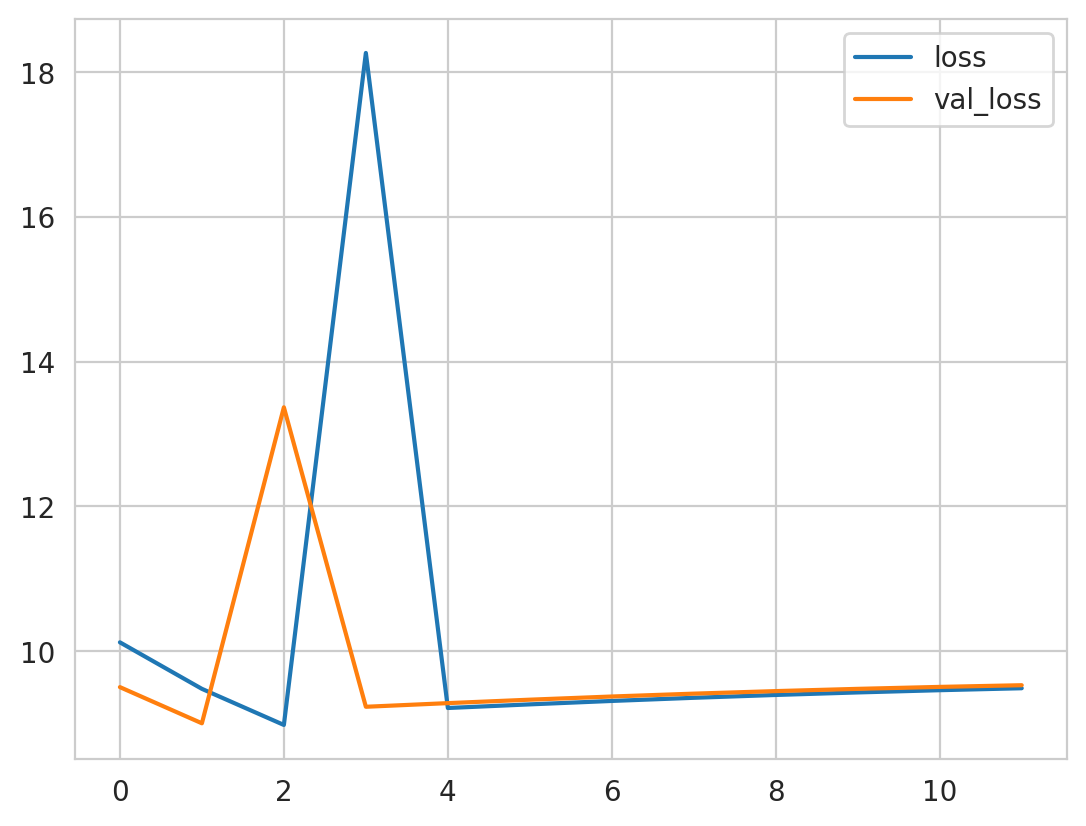

In [30]:
pd.DataFrame(history)[['loss', 'val_loss']].plot();

## Eval

In [ ]:
if LOSS == 'mse':
  y_pred = model.predict(x=x_eval, batch_size=1024).flatten()

if LOSS == 'ziln':
  logits = model.predict(x=x_eval, batch_size=1024)
  y_pred = ltv.zero_inflated_lognormal_pred(logits).numpy().flatten()

### Total Profit

In [ ]:
unit_costs = [0.4, 0.5, 0.6, 0.68, 0.7, 0.8, 0.9, 1.0]

In [ ]:
num_mailed = [np.sum(y_pred > v) for v in unit_costs]
num_mailed

In [ ]:
baseline_total_profit = np.sum(y_eval - 0.68)
baseline_total_profit

In [ ]:
total_profits = [np.sum(y_eval[y_pred > v] - v) for v in unit_costs]
total_profits

### Gini Coefficient

In [ ]:
gain = pd.DataFrame({
    'lorenz': ltv.cumulative_true(y_eval, y_eval),
    'baseline': ltv.cumulative_true(y_eval, x_eval['numeric'][:, 19]),
    'model': ltv.cumulative_true(y_eval, y_pred),
})

In [ ]:
num_customers = np.float32(gain.shape[0])
gain['cumulative_customer'] = (np.arange(num_customers) + 1.) / num_customers

In [ ]:
ax = gain[[
    'cumulative_customer',
    'lorenz',
    'baseline',
    'model',
]].plot(
    x='cumulative_customer', figsize=(8, 5), legend=True)

ax.legend(['Groundtruth', 'Baseline', 'Model'], loc='lower right')

ax.set_xlabel('Cumulative Fraction of Customers')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlim((0, 1.))

ax.set_ylabel('Cumulative Fraction of Total Lifetime Value')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim((0, 1.05))
ax.set_title('Gain Chart');

In [ ]:
gini = ltv.gini_from_gain(gain[['lorenz', 'baseline', 'model']])
gini

### Calibration

In [ ]:
df_decile = ltv.decile_stats(y_eval, y_pred)
df_decile

In [ ]:
ax = df_decile[['label_mean', 'pred_mean']].plot.bar(rot=0)

ax.set_title('Decile Chart')
ax.set_xlabel('Prediction bucket')
ax.set_ylabel('Average bucket value')
ax.legend(['Label', 'Prediction'], loc='upper left');

### Rank Correlation

In [ ]:
def spearmanr(
    x1: Sequence[float],
    x2: Sequence[float]) -> float:
  """Calculates spearmanr rank correlation coefficient.

  See https://docs.scipy.org/doc/scipy/reference/stats.html.

  Args:
    x1: 1D array_like.
    x2: 1D array_like.

  Returns:
    correlation: float.
  """
  return stats.spearmanr(x1, x2, nan_policy='raise')[0]


spearman_corr = spearmanr(y_eval, y_pred)
spearman_corr

### All metrics together

In [ ]:
df_metrics = pd.DataFrame({
    'model': MODEL,
    'loss_function': LOSS,
    'train_loss': history['loss'][-1],
    'eval_loss': history['val_loss'][-1],
    'label_positive': np.mean(y_eval > 0),
    'label_mean': y_eval.mean(),
    'pred_mean': y_pred.mean(),
    'decile_mape': df_decile['decile_mape'].mean(),
    'baseline_gini': gini['normalized'][1],
    'gini': gini['normalized'][2],
    'spearman_corr': spearman_corr,
}, index=[VERSION])

In [ ]:
for unit_cost, total_profit in zip(unit_costs, total_profits):
  df_metrics['total_profit_{:02d}'.format(int(unit_cost * 100))] = total_profit

In [ ]:
df_metrics.T

## Save

In [ ]:
output_path = OUTPUT_CSV_FOLDER

In [ ]:
if not os.path.isdir(output_path):
  os.makedirs(output_path)

In [ ]:
output_file = os.path.join(output_path, '{}_regression_{}_{}.csv'.format(MODEL, LOSS, VERSION))

In [ ]:
df_metrics.to_csv(output_file, index=False)